In [1]:
####
#required import
####

#basic
import matplotlib.pyplot as plt
import numpy as np
import torch

#utils
from functools import partial
from tqdm.notebook import tqdm,trange
import time, sys, copy

#training
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

#BDT class
import xgboost as xgb

#CFM external package
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher,SchrodingerBridgeConditionalFlowMatcher,ExactOptimalTransportConditionalFlowMatcher
from torchcfm.optimal_transport import OTPlanSampler

#some ode solver
from ode_example import *


In [2]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True


# load the dataset
# X=DATA with (n,d) shape
# y=np.zeros(len(X)) label

import h5py

file_path = 'generated/t_substructure.h5'

with h5py.File(file_path, 'r') as file:
    dataset_names = ['d12', 'd2',  'mass', 'pt', 'tau1', 'tau3']
    data_arrays = []
    
    for name in dataset_names:
        data = file[name][()]  # Read the dataset
        data_arrays.append(data)
    combined_data = np.column_stack(data_arrays)

X=combined_data[:40000]
y=np.zeros(len(X))
print(y.shape)

# shuffle the observations
new_perm = np.random.permutation(X.shape[0])
np.take(X, new_perm, axis=0, out=X)
np.take(y, new_perm, axis=0, out=y)

# Save data before adding missing values
X_true, y_true = copy.deepcopy(X), copy.deepcopy(y)
Xy_true = np.concatenate((X_true, np.expand_dims(y_true, axis=1)), axis=1)

(40000,)


In [3]:
# Main hyperparameters
n_t = 30  # number of flow steps according to the dataset
duplicate_K = 100  # number of different noise sample per real data sample (higher is better)

# XGBoost hyperparameters
max_depth = 4
n_estimators = 100
eta = 0.1
tree_method = "hist"
reg_lambda = 0.1
reg_alpha = 0.2
subsample = 1.0

In [4]:
b, c = X.shape
# Saving the freqency of the classes and storing label masks for later
y_uniques, y_probs = np.unique(y, return_counts=True)
y_probs = y_probs / np.sum(y_probs)
mask_y = {}  # mask for which observations has a specific value of y
for i in trange(len(y_uniques)):
    mask_y[y_uniques[i]] = np.zeros(b, dtype=bool)
    mask_y[y_uniques[i]][y == y_uniques[i]] = True
    mask_y[y_uniques[i]] = np.tile(mask_y[y_uniques[i]], (duplicate_K))
n_y = len(y_uniques)  # number of classes



# Min-Max scaling of the variables
X_min = np.nanmin(X, axis=0, keepdims=1)
X_max = np.nanmax(X, axis=0, keepdims=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)


X_scaled = X_scaled
# Save shape
b, c = X.shape

# we duplicate the data multiple times, so that X0 is k times bigger, so that we can have k random noise z associated per sample
X1 = np.tile(X_scaled, (duplicate_K, 1))


# Generate noise data
X0 = np.random.normal(size=X1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import os


store = False # if store the local training files for split time step training if RAM too high




# Build [X(t), y] at multiple values of t
#sigma = 1e-3
# Define SB Conditional Flow Matching (SB-CFM)
#FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma, ot_method="sinkhorn")

# Define Independent Conditional Flow Matching (I-CFM)
FM = ConditionalFlowMatcher(sigma=0.0)

# Define Independent Conditional Flow Matching (OT-CFM)
#FM = ConditionalFlowMatcher(sigma=0.0)

#ot_sampler = OTPlanSampler(method="exact")

#FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)


# Time levels
t_levels = np.linspace(1e-3, 1, num=n_t)

# Interpolation between x0 and x1 (xt)
X_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Output to predict (ut)
y_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Fill with xt and ut
for i in trange(n_t):
    t = torch.ones(X0.shape[0]) * t_levels[i]  # current t
    _, xt, ut = FM.sample_location_and_conditional_flow(
        torch.from_numpy(X0), torch.from_numpy(X1), t=t
    )
    if store == True:
        np.save(os.path.join(f'generated/X_traint_{i}.npy'), xt.numpy())
        np.save(os.path.join(f'generated/y_traint_{i}.npy'), ut.numpy())
        
    else:
        X_train[i], y_train[i] = xt.numpy(), ut.numpy()  #train here

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
def train_parallel(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        objective="reg:squarederror",
        eta=eta,
        max_depth=max_depth,
        n_jobs=16,
        #uncomment if want to do multi-output per tree
        #multi_strategy='one_output_per_tree', 
        #multi_strategy='multi_output_tree',
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        seed=666,
        tree_method=tree_method,
        device="cpu",
    )

    #y_no_miss = ~np.isnan(y_train)
    model.fit(X_train, y_train)

    return model

In [7]:
regr = Parallel(n_jobs=1)(  # using all or one cpu
    delayed(train_parallel)(
        X_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], :],
        y_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], k],
    )
    for i in trange(n_t)
    for k in trange(c)
    for j in y_uniques
)


regr_ = [[[None for k in range(c)] for i in range(n_t)] for j in y_uniques]
current_i = 0
for i in range(n_t):
    for j in range(len(y_uniques)):
        for k in range(c):
            regr_[j][i][k] = regr[current_i]
            current_i += 1
regr = regr_



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
def my_model(t, xt, mask_y=None):
    # xt is [b*c]
    xt = xt.reshape(xt.shape[0] // c, c)  # [b, c]

    # Output from the models
    out = np.zeros(xt.shape)  # [b, c]
    i = int(round(t * (n_t - 1)))
    for j, label in enumerate(y_uniques):
        for k in range(c):
            out[mask_y[label], k] = regr[j][i][k].predict(xt[mask_y[label], :])

    out = out.reshape(-1)  # [b*c]
    return out

In [9]:
batch_size = 40000
# Generate prior noise

x0 = np.random.normal(size=(batch_size, c))

# Generate random labels for the outcome
label_y_fake = y_uniques[np.argmax(np.random.multinomial(1, y_probs, size=x0.shape[0]), axis=1)]
mask_y_fake = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    mask_y_fake[y_uniques[i]] = np.zeros(x0.shape[0], dtype=bool)
    mask_y_fake[y_uniques[i]][label_y_fake == y_uniques[i]] = True

start_time = time.time() 
# ODE solve
ode_solved = dpori5_solve_numpy(
    my_model=partial(my_model, mask_y=mask_y_fake), x0=x0.reshape(-1), N=n_t
)  # [t, b*c]
end_time = time.time()
print("Total sampling time %.3f seconds" % (end_time - start_time))
solution = ode_solved.reshape(batch_size, c)  # [b, c]

# invert the min-max normalization
solution = scaler.inverse_transform(solution)
small = (solution < X_min).astype(float)
solution = small * X_min + (1 - small) * solution
big = (solution > X_max).astype(float)
solution = big * X_max + (1 - big) * solution


Xy_fake = np.concatenate((solution, np.expand_dims(label_y_fake, axis=1)), axis=1)

Total sampling time 19.460 seconds


In [10]:
gen0 = []
for i in range(len(Xy_fake)):
    if Xy_fake[i, -1] == 0:
        temp = Xy_fake[i, 0:6].copy()
        gen0.append(temp)

        
real = []
for i in range(len(Xy_true)):
    if Xy_true[i, -1] == 0:
        temp = Xy_true[i, 0:6].copy()
        real.append(temp)
        
real_array = np.array(real)
gen0_array = np.array(gen0)

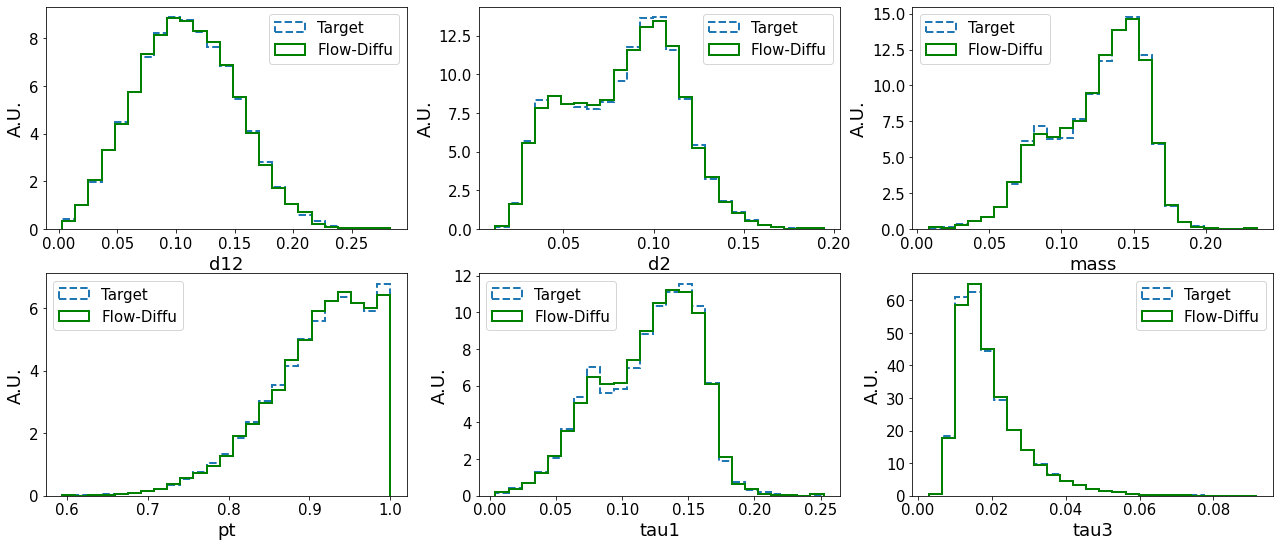

In [11]:
# Define the indices you want to plot
indices_to_plot = [0,1,2,3,4,5]
titles = ['d12', 'd2',  'mass', 'pt', 'tau1', 'tau3']
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 9))  # Adjust figsize as needed
axes = axes.flatten()
eps = 1e-10
binnum = [25,25,25,25,25,25]
for ax, index in zip(axes, indices_to_plot):
    # Histogram bins and counts for real data
    counts, binning = np.histogram(real_array[:, index], bins=binnum[index],density=True)
    counts_real, _ = np.histogram(real_array[:batch_size, index], bins=binning,density=True)
    counts_gen0, _ = np.histogram(gen0_array[:batch_size, index], bins=binning,density=True)
    # Plotting real data
    ax.hist(real_array[:, index], bins=binning, label='Target', histtype="step", linestyle='--', color='#1f77b4',lw=2,density=True)
    
    # Plotting generated data
    ax.hist(gen0_array[:, index], bins=binning, label='Flow-Diffu', histtype="step", color='green', lw=2,density=True)
    
    # Setting labels and styles
    ax.legend(fontsize=15)
    ax.set_ylabel(f'A.U.', fontsize=18)  # Dynamic y-label based on the feature index
    ax.set_xlabel(f'{titles[index]}', fontsize=18)  # Dynamic y-label based on the feature index
    ax.tick_params(axis='both', which='major', labelsize=15)